In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
import json 
import talib as ta
import math
from itertools import compress

[*********************100%***********************]  1 of 1 completed


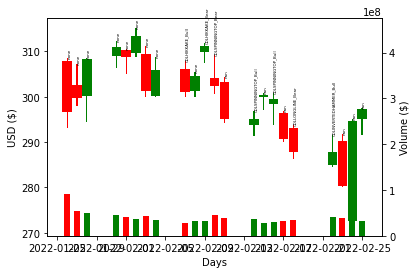

<Figure size 720x720 with 0 Axes>

In [13]:
ticker = yf.download("MSFT", period = "1mo")

candle_names = ta.get_function_groups()['Pattern Recognition']

ticker = ticker.rename(columns={
        "Date": "date",
        "Open": "open",
        "High": "high",
        "Low": "low",
        "Close": "close",
        "Adj Close": "adj_close",
        "Volume": "volume"
    }
)

op = ticker['open']
hi = ticker['high']
lo = ticker['low']
cl = ticker['close']

for candle in candle_names:
    ticker[candle] = getattr(ta, candle)(op, hi, lo, cl)

ticker['candlepattern'] = np.nan
ticker['candlematchcount'] = np.nan

for index, row in ticker.iterrows():
    if len(row[candle_names]) - sum(row[candle_names] == 0) == 0:
        ticker.loc[index, 'candlepattern'] = 'none'
        ticker.loc[index, 'candlematchcount'] = 0
    elif len(row[candle_names]) - sum(row[candle_names] == 0) == 1:
        if any(row[candle_names].values > 0):
            pattern = list(compress(
                row[candle_names].keys(),
                row[candle_names].values != 0
            ))[0] + '_Bull'
        else:
            pattern = list(compress(
                row[candle_names].keys(),
                row[candle_names].values != 0
            ))[0] + '_Bear'
        ticker.loc[index, 'candlepattern'] = pattern
        ticker.loc[index, 'candlematchcount'] = 1
    else:
        patterns = list(compress(
            row[candle_names].keys(),
            row[candle_names].values != 0
        ))
        container = []
        for pattern in patterns:
            if row[pattern] > 0:
                container.append(pattern + '_Bull')
            else:
                container.append(pattern + '_Bear')

ticker.drop(candle_names, axis = 1, inplace = True)

bar_width = 0.12
width, width2 = 8*bar_width, bar_width
up_color, dn_color = 'green', 'red'

up = ticker[ticker.close >= ticker.open]
dn = ticker[ticker.close < ticker.open]

fig, ax1 = plt.subplots()

ax1.bar(up.index, up.close-up.open, width, bottom=up.open, color=up_color)
ax1.bar(up.index, up.high-up.close, width2, bottom=up.close, color=up_color)
ax1.bar(up.index, up.low-up.open, width2, bottom=up.open, color=up_color)

ax1.bar(dn.index, dn.close-dn.open, width, bottom=dn.open, color=dn_color)
ax1.bar(dn.index, dn.high-dn.open, width2, bottom=dn.open, color=dn_color)
ax1.bar(dn.index, dn.low-dn.close, width2, bottom=dn.close, color=dn_color)

ax1.set_xlabel('Days')
ax1.set_ylabel('USD ($)')

ax2 = ax1.twinx()
ax2.bar(up.index, up.volume, bar_width*5, color=up_color)
ax2.bar(dn.index, dn.volume, bar_width*5, color=dn_color)

ymin, ymax = ax2.get_ylim()
ax2.set_ylim(0, ymax*5)
ax2.set_ylabel('Volume ($)')

for index, row in ticker.iterrows():
    ax1.annotate(row['candlepattern'], (index, row['high']+0.2), rotation=90, fontsize=4)
plt.figure(figsize=(10, 10))

plt.show()
